# Explore here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000 

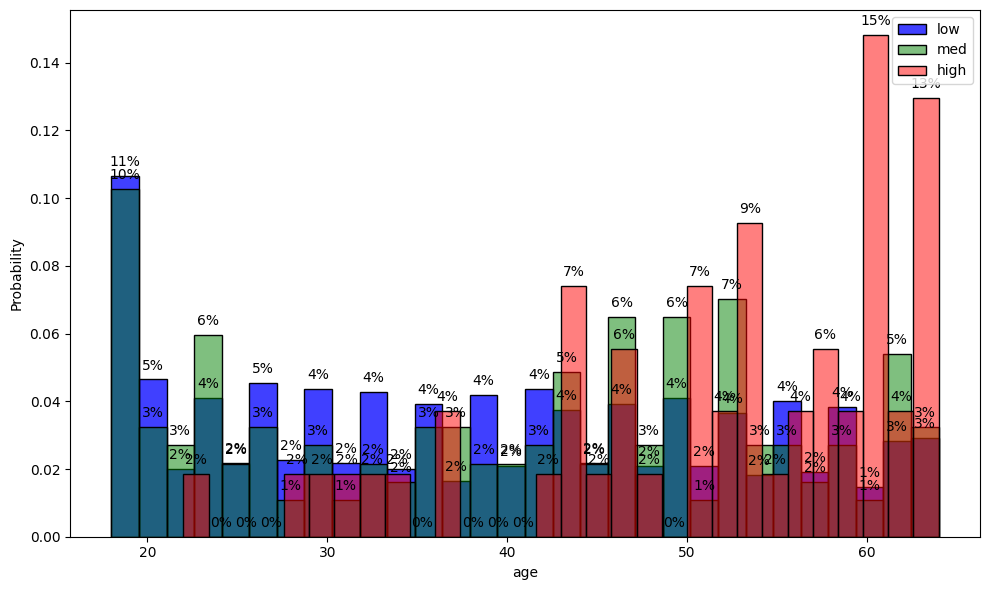

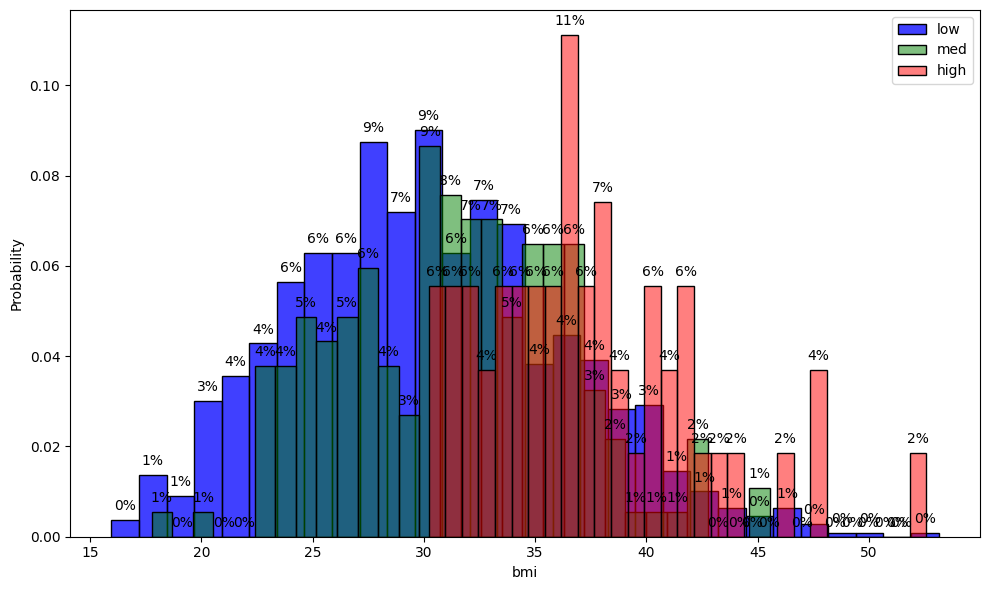

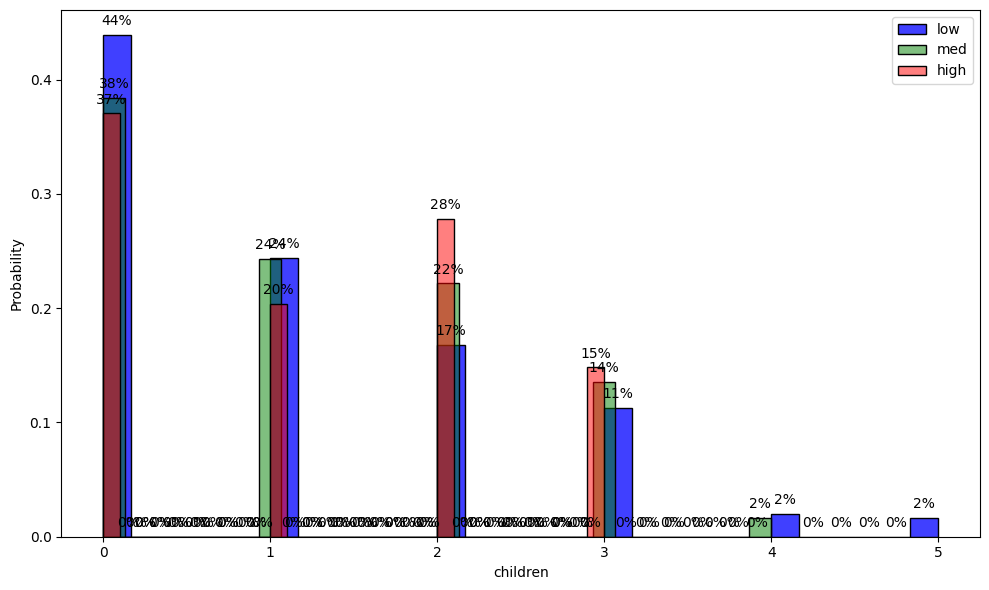

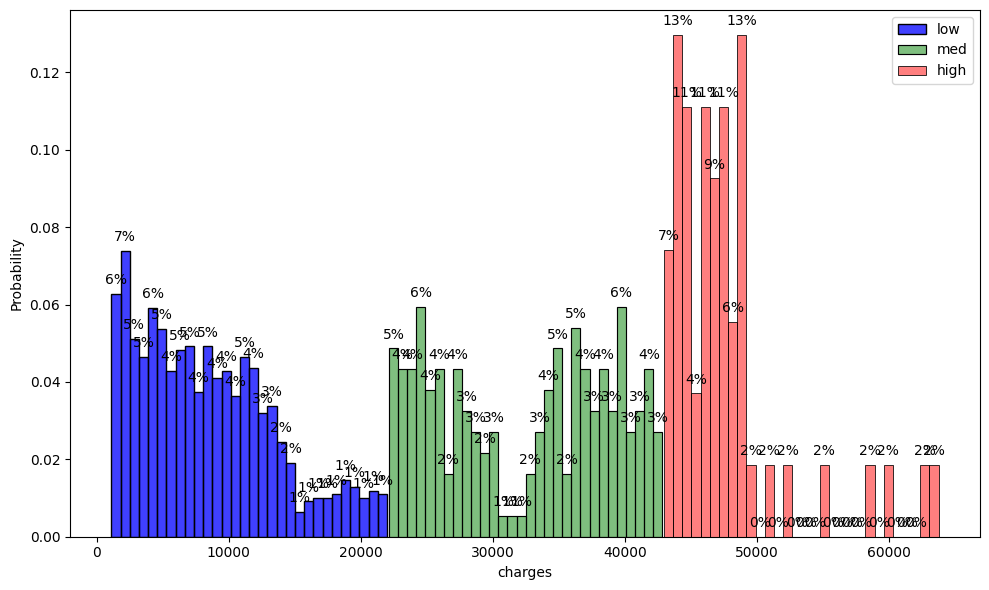

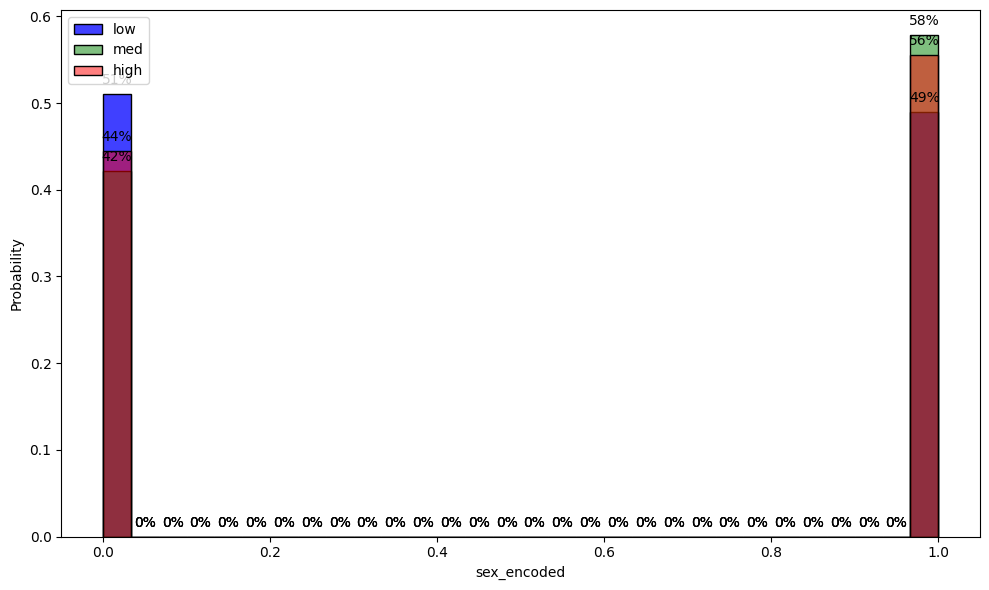

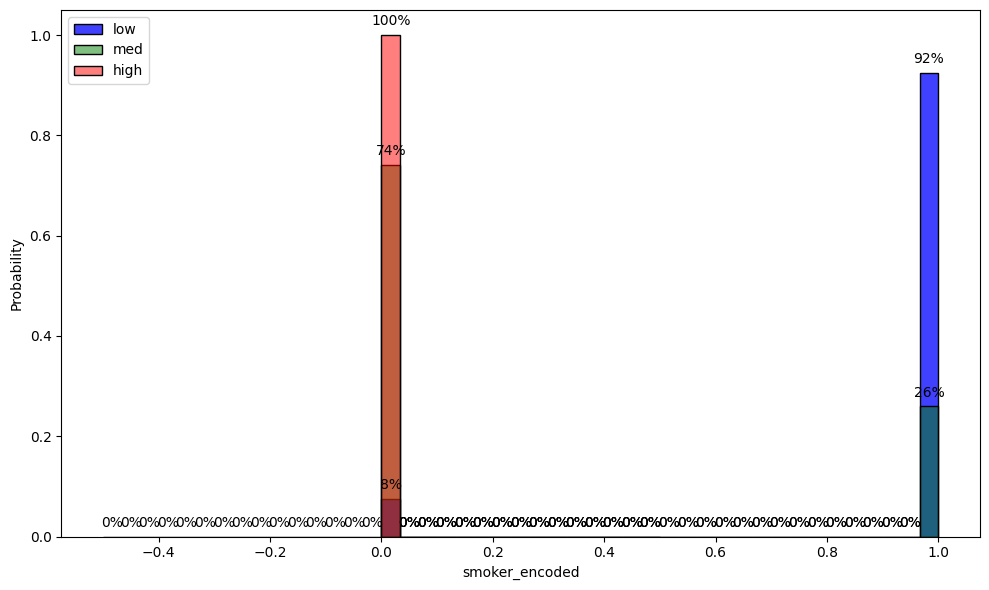

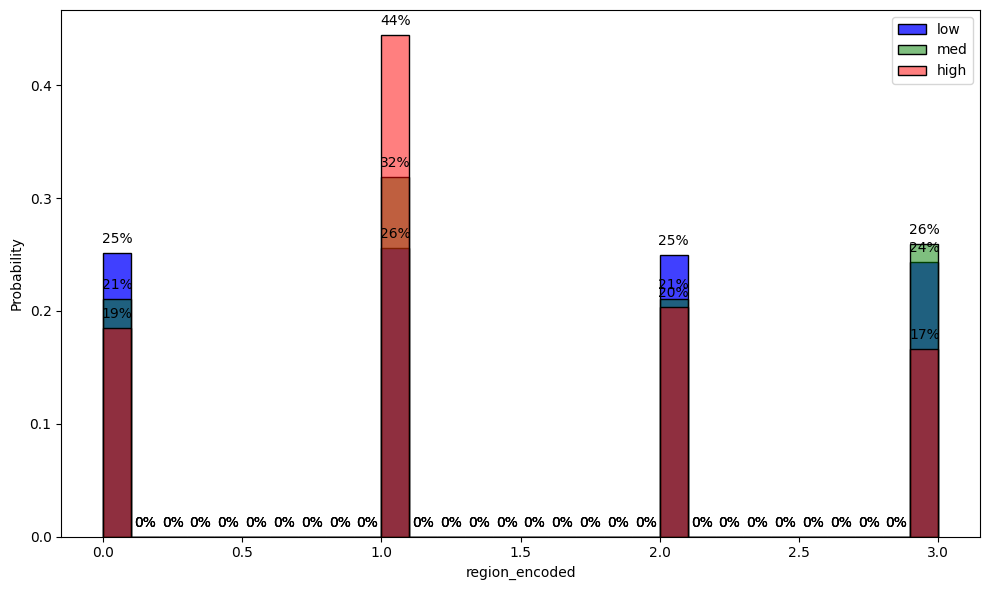

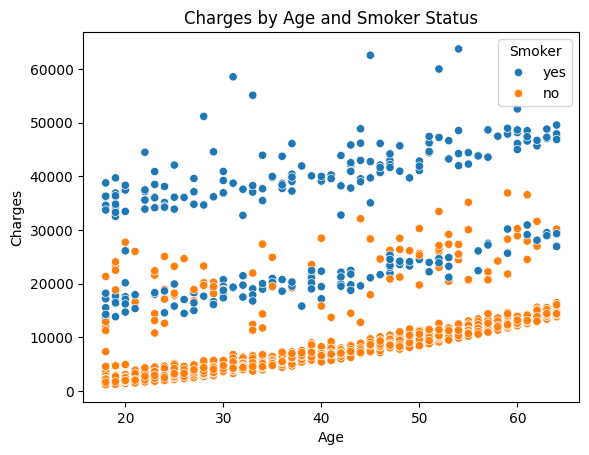

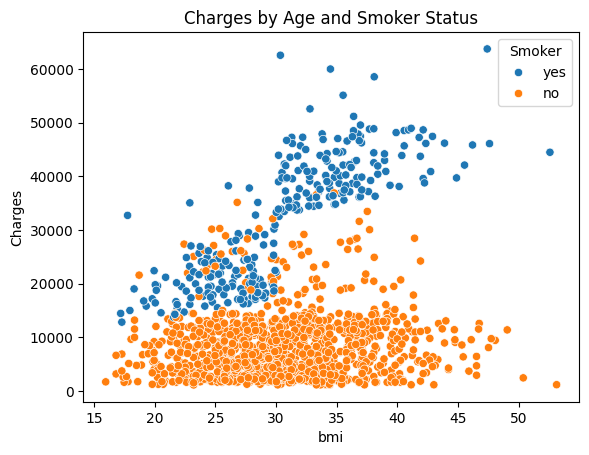

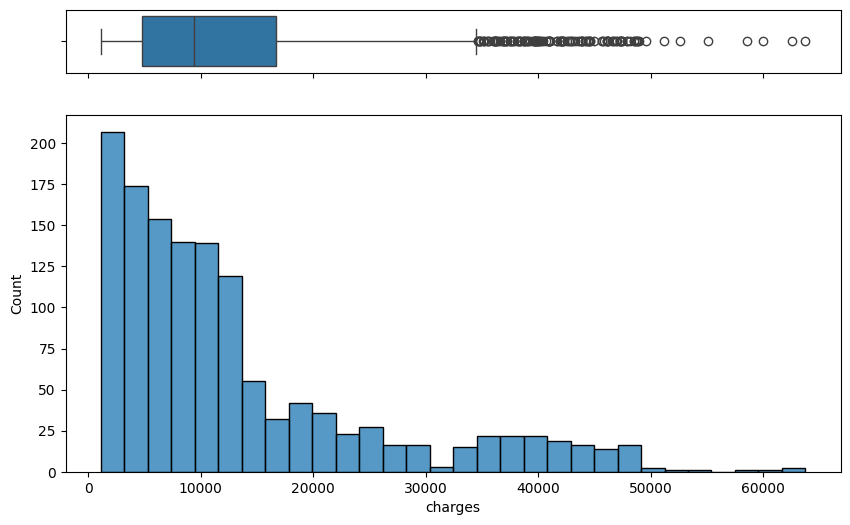

Number of charges over $50000: 7
Number of charges over $60000: 3
Number of charges over $63000: 1
q25: 4746.344, q75: 16657.71745, IQR: 11911.37345
Count of lower outliers: 0
Count of upper outliers: 6


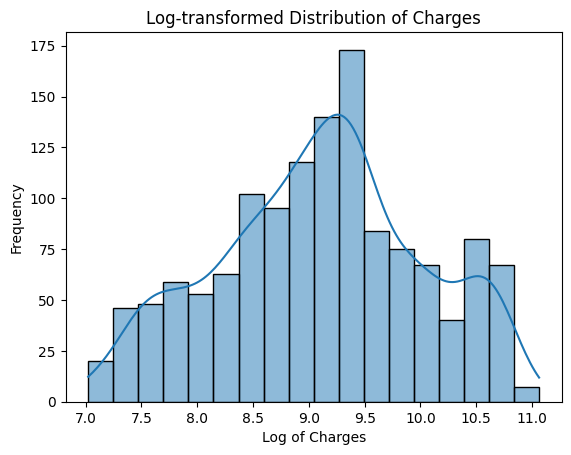

q25: 8.46512991645919, q75: 9.720628898531286, IQR: 1.2554989820720959
Count of lower outliers after tranformation: 1337
Count of upper outliers after transformation: 0
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     372.6
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          4.23e-301
Time:                        19:31:41   Log-Likelihood:                -10750.
No. Observations:                1064   AIC:                         2.152e+04
Df Residuals:                    1055   BIC:                         2.156e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std 

/tmp/ipykernel_488/1554759378.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[categorical_columns] = filtered_data[categorical_columns].apply(lambda x: x.astype('category'))


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Overview
print(f'''For charges, I explored using a log transformation as well as the skewed data. I also explored removing outliers in different ways
as well as removing them before and after the log transformation. The best performing model used the original skewed data and had
an RMSE of 4144.37''')

# State problem

'''Problem Statement: 
\The important insurance company 4Geeks Insurance S.L. wants to calculate, 
based on physiological data of its customers what will be the premium (cost) to be borne by each of them. 
To do this, it has assembled a whole team of doctors and based on data from other companies 
and a particular study have managed to gather a set of data to train a predictive model.\n'''

# Read data
total_data = pd.read_csv('/workspaces/machine-learning-python-template-ds-2023/Ryan/raw/medical_insurance.csv')

# See info
print(total_data.info())

# See data
print(total_data.head())

# Categorize columns
numerical_columns = total_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = total_data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
target = ['charges', 'log_charges']

# Describe columns
print(total_data[numerical_columns].describe())

# Factorize categorical for EDA
for col in categorical_columns:
    labels, unique_categories = pd.factorize(total_data[col])
    total_data[col + '_encoded'] = labels  # Adding an encoded column
    print(f"Factorization for {col}:")
    for index_r, category_r in enumerate(unique_categories):
        print(f"{category_r}: {index_r}")
    print("\n")

# Check for duplicates
print(f'''Duplicated: {total_data.duplicated().sum()}''')
duplicates = total_data[total_data.duplicated()]
print(duplicates)
total_data.drop_duplicates(inplace=True)

# Separate data based on charges
total_data['binned_charges'] = pd.cut(total_data['charges'], bins=3, labels=[0, 1, 2])

low_filtered_data = total_data[total_data['binned_charges'] == 0]
med_filtered_data = total_data[total_data['binned_charges'] == 1]
high_filtered_data = total_data[total_data['binned_charges'] == 2]

# Plot histograms
encoded_categorical_columns = [col + '_encoded' for col in categorical_columns]
hist_columns = numerical_columns + encoded_categorical_columns

for column in hist_columns:
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()

    # Plot data
    sns.histplot(low_filtered_data[column], kde=False, stat='probability', label='low', bins=30, color='blue', ax=ax)
    sns.histplot(med_filtered_data[column], kde=False, stat='probability', label='med', bins=30, color='green', alpha=0.5, ax=ax)
    sns.histplot(high_filtered_data[column], kde=False, stat='probability', label='high', bins=30, color='red', alpha=0.5, ax=ax)

    # Getting all the rectangles (bar patches) in the current axes
    patches = ax.patches

    # Iterate over bar heights and annotate with their percentage
    for patch in patches:
        bar = patch.get_height()
        # Annotate the percentage on top of the bars
        plt.annotate(f"{round(bar*100)}%", (patch.get_x() + patch.get_width() / 2., bar), 
                     ha='center', va='center', xytext=(0,10), textcoords='offset points')
    
    # Set label and legends
    plt.xlabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Age * Smoker 
sns.scatterplot(data=total_data, x='age', y='charges', hue='smoker')
plt.title('Charges by Age and Smoker Status')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()

# BMI * Smoker 
sns.scatterplot(data=total_data, x='bmi', y='charges', hue='smoker')
plt.title('Charges by Age and Smoker Status')
plt.xlabel('bmi')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()

# Set up the matplotlib figure (you can adjust the size as needed)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                     gridspec_kw={"height_ratios": (.15, .85)}, 
                                     figsize=(10, 6))

# Create a boxplot
sns.boxplot(data=total_data, x='charges', ax=ax_box)

# Create a histogram
sns.histplot(data=total_data, x='charges', ax=ax_hist, bins=30)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Display the plot
plt.show()

# Outliers before log transformation
count_over_50000 = (total_data['charges'] > 50000).sum()
count_over_60000 = (total_data['charges'] > 60000).sum()
count_over_63000 = (total_data['charges'] > 63000).sum()
print(f"Number of charges over $50000: {count_over_50000}")
print(f"Number of charges over $60000: {count_over_60000}")
print(f"Number of charges over $63000: {count_over_63000}")

q25 = total_data['charges'].quantile(0.25)
q75 = total_data['charges'].quantile(0.75)
IQR = q75-q25
print(f'''q25: {q25}, q75: {q75}, IQR: {IQR}''')

outlier_factor = 3

total_data['charges'+"_lower_outliers"] = np.where(total_data['charges'] < q25-outlier_factor*IQR, 1,0)
total_data['charges'+"_upper_outliers"] = np.where(total_data['charges'] > q75+outlier_factor*IQR, 1, 0)

# Count of lower outliers
lower_outliers_count = total_data['charges_lower_outliers'].sum()
print(f"Count of lower outliers: {lower_outliers_count}")

# Count of upper outliers
upper_outliers_count = total_data['charges_upper_outliers'].sum()
print(f"Count of upper outliers: {upper_outliers_count}")

# Log transformation
total_data['log_charges'] = np.log(total_data['charges'])

# Visualize the distribution of the transformed 'charges'
sns.histplot(total_data['log_charges'], kde=True)
plt.title('Log-transformed Distribution of Charges')
plt.xlabel('Log of Charges')
plt.ylabel('Frequency')
plt.show()

# Outliers after log transformation
q25_t = total_data['log_charges'].quantile(0.25)
q75_t = total_data['log_charges'].quantile(0.75)
IQR_t = q75_t-q25_t
print(f'''q25: {q25_t}, q75: {q75_t}, IQR: {IQR_t}''')

outlier_factor = 3

total_data['log_charges'+"_lower_outliers"] = np.where(total_data['log_charges'] < q25-outlier_factor*IQR_t, 1,0)
total_data['log_charges'+"_upper_outliers"] = np.where(total_data['log_charges'] > q75+outlier_factor*IQR_t, 1, 0)

# Count of lower outliers
lower_outliers_count_t = total_data['log_charges_lower_outliers'].sum()
print(f"Count of lower outliers after tranformation: {lower_outliers_count_t}")

# Count of upper outliers
upper_outliers_count_t = total_data['log_charges_upper_outliers'].sum()
print(f"Count of upper outliers after transformation: {upper_outliers_count_t}")

# Corrected filtering using pandas directly
filtered_data = total_data[total_data['charges_upper_outliers'] != 1]

# Convert categorical columns to 'category' dtype if they aren't already
filtered_data[categorical_columns] = filtered_data[categorical_columns].apply(lambda x: x.astype('category'))

# Assuming 'numerical_columns', 'categorical_columns', and 'target' are predefined lists
X_num_columns = [col for col in numerical_columns if col not in target]
X_num = filtered_data[X_num_columns]
X_cat = filtered_data[categorical_columns]

# It's good to convert categorical columns to 'category' dtype if they aren't already
for col in categorical_columns:
    if col in filtered_data.columns:
        filtered_data.loc[:, col] = filtered_data[col].astype('category')


# Formula1 With Outliers RMSE: 5956.34, Without Outliers RMSE: 5589.12
formula1 = 'charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)'
y, X = dmatrices(formula1, data=filtered_data, return_type='dataframe')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = sm.OLS(y_train, X_train)
results = model1.fit()

# Formula2 With Outliers RMSE: 4494.23, Without Outliers RMSE: 4144.37, Log Scale With Outliers: 4586.2 Log Scale Without Outliers: 4699.62
#logformula2 = 'log_charges ~ age + bmi + I(age**2) + C(smoker) + C(smoker)*bmi + C(region)'
formula2 = 'charges ~ age + bmi + I(age**2) + I(bmi**2) + I(bmi**3) + I(bmi**4) + C(smoker) + C(smoker)*bmi + C(region)'

y_2, X_2 = dmatrices(formula2, data=filtered_data, return_type='dataframe')

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

model2 = sm.OLS(y_train_2, X_train_2)
results_2 = model2.fit()

# Print the summary of the model
print(results.summary())
print(results_2.summary())

# Formula1 predicitons
y_pred = results.predict(X_test)

# Formula2 predicitons
y_pred_2 = results_2.predict(X_test_2)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

print(f"Mean squared error_2: {mean_squared_error(y_test_2, y_pred_2)}")
print(f"Coefficient of determination_2: {r2_score(y_test_2, y_pred_2)}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean squared error: {rmse}")

rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_2))
print(f"Root mean squared error_2: {rmse_2}")

# Get descriptive statistics of the 'charges' column
charges_stats = filtered_data['charges'].describe()

print(f"Statistics for 'charges':\n{charges_stats}")

# Compare RMSE with the standard deviation and the range of 'charges'
print(f"Standard Deviation of 'charges': {charges_stats['std']}")
print(f"Range of 'charges': {charges_stats['max'] - charges_stats['min']}")

# # Calculate MSE on the log scale
# mse_log = mean_squared_error(y_test_2, y_pred_2)

# # RMSE on the log scale
# rmse_log = np.sqrt(mean_squared_error(y_test_2, y_pred_2))
# print(f"Root mean squared error on log scale: {rmse_log}")

# # # Back-transform the RMSE to the original scale using the exponent
# # rmse_original_scale = np.exp(rmse_log)  # This is not the exact RMSE on the original scale, but it is one approach.

# # Get descriptive statistics of the 'charges' column before the log transformation
# charges_stats = total_data['charges'].describe()

# print(f"Statistics for 'charges':\n{charges_stats}")

# # Compare RMSE with the standard deviation and the range of 'charges'
# print(f"Standard Deviation of 'charges': {charges_stats['std']}")
# print(f"Range of 'charges': {charges_stats['max'] - charges_stats['min']}")

# # # Back-transform RMSE using median approach as an approximation
# # median_charges = np.exp(np.median(y_test_2))
# # rmse_original_scale_approx = (np.exp(rmse_log) - 1) * median_charges

# # print(f"Approximated RMSE on original scale: {rmse_original_scale_approx}")